# Star-forming versus queiscent

In [1]:
import os
import h5py 
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

In [2]:
import corner as DFM

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.sfr.hdf5'))

In [6]:
has_posterior = (bgs['provabgs_z_max'].data != -999.)

In [7]:
bgs = bgs[has_posterior]

In [8]:
logsfr = np.log10(np.median(bgs['provabgs_avgSFR1Gyr_mcmc'].data, axis=1))
logm = bgs['provabgs_logMstar_bf'].data

In [9]:
zlim = (bgs['Z_HP'] < 0.2)

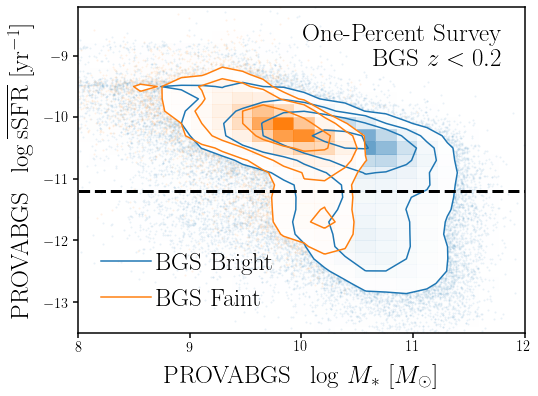

In [10]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

DFM.hist2d(logm[zlim & bgs['is_bgs_bright']], (logsfr-logm)[zlim & bgs['is_bgs_bright']], 
           bins=30, range=((7., 12.5), (-14., -8)), color='C0', ax=sub)
DFM.hist2d(logm[zlim & bgs['is_bgs_faint']], (logsfr-logm)[zlim & bgs['is_bgs_faint']], 
           bins=30, range=((7., 12.5), (-14., -8)), color='C1', ax=sub)
sub.plot([7., 12.5], [-11.2, -11.2], color='k', linestyle='--', linewidth=3)

sub.plot([], [], color='C0', label='BGS Bright')
sub.plot([], [], color='C1', label='BGS Faint')
sub.legend(loc='lower left', handletextpad=0.2, fontsize=25)

sub.set_xlabel(r"PROVABGS $~\log$ $M_*$ [$M_\odot$]", labelpad=10, fontsize=25)
sub.set_xlim(8., 12.)
sub.set_xticks([8., 9., 10., 11., 12.])
sub.set_ylabel(r"PROVABGS $~\log \overline{\rm sSFR}$ [${\rm yr}^{-1}$]", labelpad=10, fontsize=25)
sub.set_ylim(-13.5, -8.2)
sub.text(0.95, 0.95, r'One-Percent Survey'+'\n'+r'BGS $z < 0.2$', 
         ha='right', va='top', fontsize=25, transform=sub.transAxes)
fig.savefig('../figs/sfq.pdf', bbox_inches='tight')

In [5]:
zmins = np.array([0.01, 0.05, 0.09, 0.13])#, 0.17])
zmaxs = np.array([0.05, 0.09, 0.13, 0.17])#, 0.21])

In [6]:
# read in stellar mass completeness limits
dat_dir = '/tigress/chhahn/provabgs/svda'
_Mlims = np.loadtxt(os.path.join(dat_dir, 'psmf.logmstar_comp_limit.dat'), unpack=True, usecols=[2])
Mlims = _Mlims[1::2]

In [7]:
psmfs = [] 
for zmin, zmax in zip(zmins, zmaxs): 
    psmf = np.loadtxt(os.path.join(dat_dir, 'psmf.sv3.bgs_bright.z%.2f_%.2f.dat' % (zmin, zmax)), 
                      skiprows=2)
    psmfs.append(psmf)

In [8]:
psmfs_q = [] 
for zmin, zmax in zip(zmins, zmaxs): 
    psmf = np.loadtxt(os.path.join(dat_dir, 'psmf.sv3.bgs_bright_q.z%.2f_%.2f.dat' % (zmin, zmax)), 
                      skiprows=2)
    psmfs_q.append(psmf)

In [9]:
psmfs_sf = [] 
for zmin, zmax in zip(zmins, zmaxs): 
    psmf = np.loadtxt(os.path.join(dat_dir, 'psmf.sv3.bgs_bright_sf.z%.2f_%.2f.dat' % (zmin, zmax)), 
                      skiprows=2)
    psmfs_sf.append(psmf)

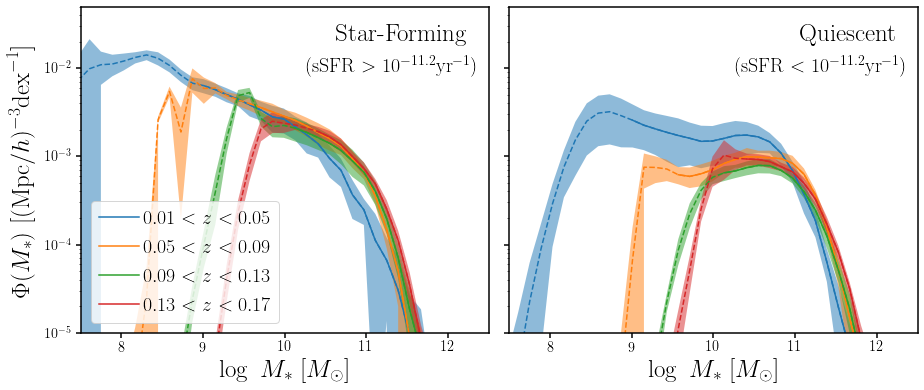

In [10]:
fig = plt.figure(figsize=(15,6))

sub = fig.add_subplot(121)


for i, zmin, zmax in zip(range(4), zmins, zmaxs):    
    
    sub.plot(psmfs_sf[i][:,0], psmfs_sf[i][:,1], color='C%i' % i, ls='--')
    sub.plot(psmfs_sf[i][:,0][psmfs_sf[i][:,0] > Mlims[i]], 
             (psmfs_sf[i][:,1])[psmfs_sf[i][:,0] > Mlims[i]], 
             c='C%i' % i, ls='-')

    sub.fill_between(psmfs_sf[i][:,0], 
                     psmfs_sf[i][:,1] - psmfs_sf[i][:,2], 
                     psmfs_sf[i][:,1] + psmfs_sf[i][:,2], 
                     color='C%i' % i, edgecolor='none', alpha=0.5)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))
sub.legend(loc='lower left', fontsize=20, markerscale=4, handletextpad=0.2, frameon=True)

sub.text(0.95, 0.95, r'Star-Forming',
         ha='right', va='top', fontsize=25, transform=sub.transAxes)
sub.text(0.975, 0.85, r'(sSFR $> 10^{-11.2}{\rm yr}^{-1}$)',
         ha='right', va='top', fontsize=20, transform=sub.transAxes)
sub.set_xlabel(r'$\log~M_*$  [$M_\odot$]', fontsize=25)
sub.set_xlim(7.5, 12.5)
sub.set_ylabel(r'$\Phi(M_*)$  [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', labelpad=10, fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-5, 5e-2)

sub = fig.add_subplot(122)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):    
    
    sub.plot(psmfs_q[i][:,0], psmfs_q[i][:,1], color='C%i' % i, ls='--')
    sub.plot(psmfs_q[i][:,0][psmfs_q[i][:,0] > Mlims[i]], 
             (psmfs_q[i][:,1])[psmfs_q[i][:,0] > Mlims[i]], 
             c='C%i' % i, ls='-')

    sub.fill_between(psmfs_q[i][:,0], 
                     psmfs_q[i][:,1] - psmfs_q[i][:,2], 
                     psmfs_q[i][:,1] + psmfs_q[i][:,2], 
                     color='C%i' % i, edgecolor='none', alpha=0.5)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

#sub.legend(loc='lower left', fontsize=20, markerscale=5, frameon=True)
sub.text(0.95, 0.95, r'Quiescent', 
         ha='right', va='top', fontsize=25, transform=sub.transAxes)
sub.text(0.975, 0.85, r'(sSFR $< 10^{-11.2}{\rm yr}^{-1}$)',
         ha='right', va='top', fontsize=20, transform=sub.transAxes)
sub.set_xlabel(r'$\log~M_*$  [$M_\odot$]', fontsize=25)
sub.set_xlim(7.5, 12.5)
sub.set_yscale('log')
sub.set_ylim(1e-5, 5e-2)
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.05)
fig.savefig('../figs/psmf_bgs_bright_sfq.pdf', bbox_inches='tight')

/home/chhahn/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/chhahn/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/chhahn/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/chhahn/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chhahn/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in mult

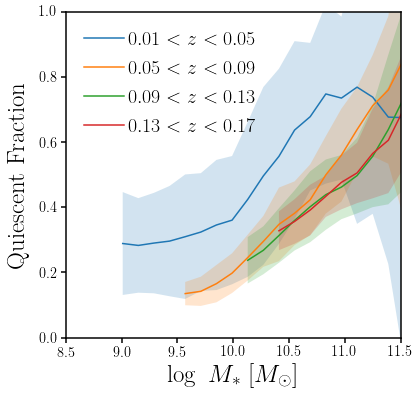

In [16]:
fig = plt.figure(figsize=(6,6))

sub = fig.add_subplot(111)
for i, zmin, zmax in zip(range(4), zmins, zmaxs):    
    
    #fq = (psmfs_q[i][:,1]/(psmfs[i][:,1]))
    #sig_fq = fq*np.sqrt((psmfs_q[i][:,2]/psmfs_q[i][:,1])**2 + (psmfs[i][:,2]/psmfs[i][:,1])**2)
    fq = (psmfs_q[i][:,1]/(psmfs_q[i][:,1] + psmfs_sf[i][:,1]))
    sig_fq = fq*np.sqrt((psmfs_q[i][:,2]/psmfs_q[i][:,1])**2 + 
                        (np.sqrt(psmfs_q[i][:,2]**2+psmfs_sf[i][:,2]**2)/(psmfs_q[i][:,1]+psmfs_sf[i][:,1]))**2)
    
    #sub.plot(psmfs_q[i][:,0][(psmfs_q[i][:,1] > 0)], 
    #         fq[(psmfs_q[i][:,1] > 0)], 
    #         c='C%i' % i, ls='--')
    sub.plot(psmfs_q[i][:,0][(psmfs_q[i][:,0] > Mlims[i]) & (psmfs_q[i][:,1] > 0)], 
             fq[(psmfs_q[i][:,0] > Mlims[i]) & (psmfs_q[i][:,1] > 0)], 
             c='C%i' % i, ls='-')
    
    sub.fill_between(psmfs_q[i][:,0][(psmfs_q[i][:,0] > Mlims[i]) & (psmfs_q[i][:,1] > 0)], 
                     (fq - sig_fq)[(psmfs_q[i][:,0] > Mlims[i]) & (psmfs_q[i][:,1] > 0)],
                     (fq + sig_fq)[(psmfs_q[i][:,0] > Mlims[i]) & (psmfs_q[i][:,1] > 0)],
                     color='C%i' % i, edgecolor='none', alpha=0.2)
    sub.plot([], [], c='C%i' % i, label='$%.2f < z < %.2f$' % (zmin, zmax))

sub.legend(loc='upper left', fontsize=20, markerscale=5, handletextpad=0.2)#, frameon=True)
sub.set_xlabel(r'$\log~M_*$  [$M_\odot$]', fontsize=25)
sub.set_xlim(8.5, 11.5)
sub.set_ylabel(r'Quiescent Fraction', labelpad=10, fontsize=25)
#sub.set_yscale('log')
sub.set_ylim(0., 1.)

fig.savefig('../figs/qf_bgs_bright.pdf', bbox_inches='tight')